<a href="https://colab.research.google.com/github/afirdousi/pytorch-basics/blob/main/005_pytorch_workflows_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# This is a copy of the workflow-2, search for "workflow-3 starts here"

In [5]:
import torch
from torch import nn # (https://pytorch.org/docs/stable/nn.html)
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

print("Intro to Pytorch Workflow")
print(torch.__version__)

Intro to Pytorch Workflow
2.0.1+cu118


In [6]:
# Build a Model
# Our First Model

# PyTorch has four (give or take) essential modules you can use to create almost
# any kind of neural network you can imagine.

# They are torch.nn, torch.optim, torch.utils.data.Dataset and
# torch.utils.data.DataLoader. For now, we'll focus on the first two and get to
# the other two later (though you may be able to guess what they do).

# How Gradient Descent works? Watch: https://www.youtube.com/watch?v=IHZwWFHWa-w
# What is Backpropagation? Watch: https://www.youtube.com/watch?v=Ilg3gGewQ5U

class LinearRegressionModel(nn.Module): # nn.Module is NN lego block
  def __init__(self):
    super().__init__()

    # FYI, we don't necessarily have to start with random/unknown params
    self.weights = nn.Parameter(torch.randn(1, # start with random weight
                                            dtype=torch.float),
                                # update weights with gradient descent
                                # pytorch will track gradient of this specific
                                # parameter for use with torch.autograd
                                            requires_grad=True)

    # nn.Parameter when used as part of a module, becomes
    # part of Module.Parameters iterator

    self.bias = nn.Parameter(torch.randn(1, # start with random bias
                                         dtype=torch.float),
                             # update weights with gradient descent
                             requires_grad=True)

  # forward defines the model computation
  # any class that inherits from nn.Module needs to implement the forward method
  def forward(self, x: torch.Tensor):
    return self.weights * x + self.bias # y = mX + b (linear regression)

In [7]:
# What happens if create an instance of our model class?

# Check contents of PyTorch model

# For sake of learning, Create a random seed
torch.manual_seed(42) # to make sure the internal random numbers generated for 'weights' and 'bias' are the same everytime (only for learning purpose)

# create a model
model_one = LinearRegressionModel()

# check out parameters
model_one

LinearRegressionModel()

In [8]:
list(model_one.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named parameters
model_one.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [10]:
# In Reality, the model starts off with some random values like this
# and use gradient descent to get to the target value

# Lets assume a target value for our parameters
weight = 0.7
bias = 0.3



# Let's recreate some dummy data that we created in last lesson as well
# To check how well does our model performs predicting

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

# Lets also redefine plot prediction function
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});



In [11]:
# the work of the model should be to go from random value to the above 2 values use gradient decent and back propagation

In [12]:
# Making predictions using torch.inference_mode()

# Disable all gradient related information. Runs faster since we are not training the model, we are just doing inference
# To test, check the output of y_predictions = model_one(X_test) without inference mode
with torch.inference_mode():
  y_predictions = model_one(X_test)


# Learn more about inference mode here: https://twitter.com/PyTorch/status/1437838231505096708?lang=en

In [13]:
# Lets check predictions

print(f"Number of testing samples = { len(X_test) }")
print(f"Number of predictions = { len(y_predictions) }")

Number of testing samples = 10
Number of predictions = 10


In [14]:
print(f"Predictions= { y_predictions }")

Predictions= tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


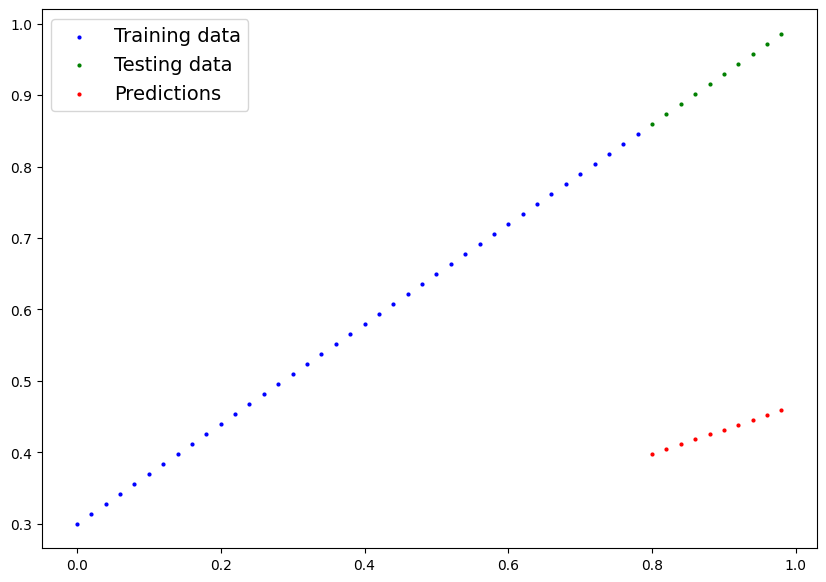

In [15]:
plot_predictions(X_train,
                 y_train,
                 X_test,
                 y_test,
                 y_predictions)

In [16]:
# The whole idea of training is to start from random and get as closer to the actual result
# by continuousing calculating how poor model predictions are by using a Loss Function

# More on Loss Functions here https://pytorch.org/docs/stable/nn.html#loss-functions
# Loss Function also called Cost function or criterion

# Loss function tries to improve the prediction by using something called Optimizer

# Optimizer: Takes into account the loss of a model and adjusts the model's paramters (e.g. weights and bias in our case)
# to improve the loss function. More here: https://pytorch.org/docs/stable/optim.html

# Which params we have in our model? Check:
model_one.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [17]:
# Next, we need now need 1/ Training Loop 2/ Testing Loop

In [18]:
# Setting Up A Loss Function & Optimizer

# In Pytorch:
# L1 Loss = Mean Absolute Error
# L2 Loss = Mean Square Error
# and there are many others, see more here: https://pytorch.org/docs/stable/nn.html#loss-functions

# If we write L1 loss ourselves, we could write:
# MAE_loss = torch.mean(torch.abs(y_predictions - y_test))

# In PyTorch, we can use builtin one MAE_loss = torch.nn.L1Loss

# Setup a loss function
loss_func = nn.L1Loss() # Loss function measures how wrong our model is

# Setup an optimizer (SGD = Stocastic Gradient Descent)
# Optimizer adjust our model parameters no matter there is
# 2 params (like weight and bias in our case) or there are millions or even billions of parameters
optimizer_func = torch.optim.SGD(model_one.parameters(),
                                 lr=0.01) # Learning Rate (its a hyperparameter) play with 0.001 as well

# Parameters are values model sets itself
# Hyperparameter are parameters we set oursevlves (as a Data Scientist or ML Engineer)
# Technically we can set `lr` to whatever value, this comes from a lot of trail and error
# The smaller the learning rate, the smaller the change in parameter to improve it

In [19]:
# Question: Which loss functiona and which optimizer to use for which problem?
# Answer: There are specific loss function and optimizers for specific type of problems
# For example, there are specific loss functions and optimizers for regression vs classification task

In [20]:
# Building a Training Loop (and testing loop) in Pytorch
# Write now, we are doing all step by step, later we will write functions to do it

# Things to do:
# 0. Loop through data
# 1. Forward Pass (moving data through forward() function) to make predictions on data aka forward propagation
# 2. Optimizer zero grad
# 3. Loss backward (Backpropgation) - move backwards through the network to calculate the gradients of each of the parameters of our model with respect to loss
# 4. Optimizer step (Gradient Descent) - use the optimizer to adjust our model's parameters to try and improve the loss

In [21]:
# Previous code copied here without comments
# We will use our new tracking variables this time

# Track values
epoch_count = []
loss_values = []
test_loss_values = []

epochs = 500

# Step.0: Loop through the data
for epoch in range(epochs):
  # Set the model to training mode
  model_one.train()

  # Step.1: Forward pass
  y_predictions = model_one(X_train)

  # Step.2: Calculate loss
  loss = loss_func(y_predictions, y_train)

  # Step.3: Optimizer zero grad
  optimizer_func.zero_grad() # start fresh every loop

  # Step.4: Peform Backpropagation
  loss.backward()

  # Step.5: Step the optimizer (Peform Gradient Descent)
  optimizer_func.step()

  # Testing
  model_one.eval()

  with torch.inference_mode():
    # In testing mode, we still following steps:

    # 1. Do the forward pass
    test_predictions = model_one(X_test)

    # 2. Calculate the (test) loss
    test_loss = loss_func(test_predictions, y_test)

  if epoch % 10 == 0: # only print a few
    epoch_count.append(epoch)
    loss_values.append(loss) # ideally should append loss.detach().numpy()
    test_loss_values.append(test_loss) # ideall should append .detach().numpy()
    print(f"Epoch: {epoch} | Train loss: { loss } | Test loss: {test_loss}")

model_one.state_dict()

# Run the above code multiple times to continuously see the model learning (and see the loss function going down)
# You can also increase epoch to some big number to run all iterations at once

Epoch: 0 | Train loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 10 | Train loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch: 20 | Train loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 30 | Train loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch: 40 | Train loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch: 50 | Train loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch: 60 | Train loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch: 70 | Train loss: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch: 80 | Train loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 90 | Train loss: 0.02788739837706089 | Test loss: 0.06473556160926819
Epoch: 100 | Train loss: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch: 110 | Train loss: 0.021020207554101944 | Test loss: 0.04819049686193466
Epoch: 120 | Train loss: 0.01758546568453312 | Test loss: 0.040604822337627

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

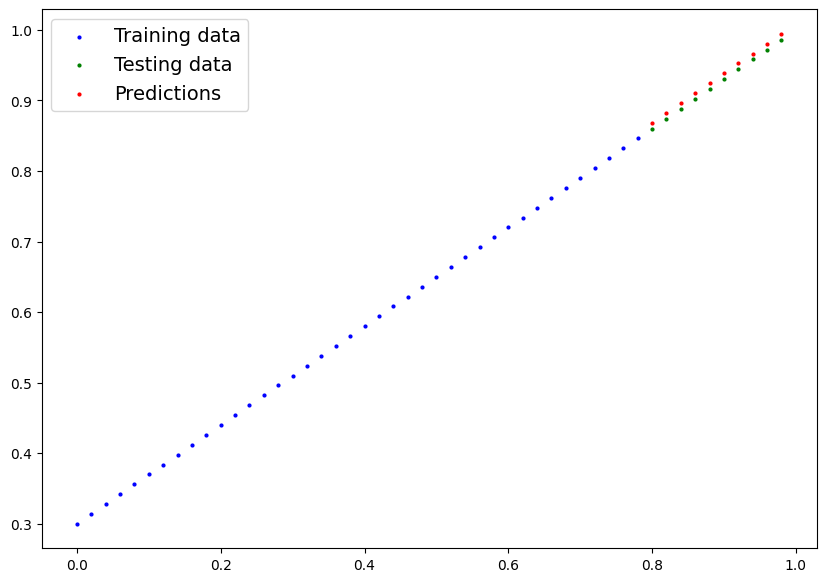

In [22]:
plot_predictions(predictions = test_predictions);

In [23]:
# Lets check tracker variables and then visualize in next steps

print(epoch_count),
print(loss_values), # note that they are tensors
print(test_loss_values) # note that they are tensors

# What we are trying to find here is when training with more epochs starts diminishing returns

[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380, 390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490]
[tensor(0.3129, grad_fn=<MeanBackward0>), tensor(0.1977, grad_fn=<MeanBackward0>), tensor(0.0891, grad_fn=<MeanBackward0>), tensor(0.0531, grad_fn=<MeanBackward0>), tensor(0.0454, grad_fn=<MeanBackward0>), tensor(0.0417, grad_fn=<MeanBackward0>), tensor(0.0382, grad_fn=<MeanBackward0>), tensor(0.0348, grad_fn=<MeanBackward0>), tensor(0.0313, grad_fn=<MeanBackward0>), tensor(0.0279, grad_fn=<MeanBackward0>), tensor(0.0245, grad_fn=<MeanBackward0>), tensor(0.0210, grad_fn=<MeanBackward0>), tensor(0.0176, grad_fn=<MeanBackward0>), tensor(0.0142, grad_fn=<MeanBackward0>), tensor(0.0107, grad_fn=<MeanBackward0>), tensor(0.0073, grad_fn=<MeanBackward0>), tensor(0.0039, grad_fn=<MeanBackward0>), tensor(0.0089, grad_fn=<MeanBackward0>), tensor(0.0089, grad_f

In [24]:
# lets visualize (uncomment and try to run below and get the error mentioned)
# plt.plot(epoch_count, loss_values, label = "Train loss") # if you run it like this, you will get RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

# Because its tensor values, we have to convert them into numpy values for plotting

In [25]:
# try to convert them to numpy values
print(np.array(torch.tensor(loss_values).numpy()))


[0.31288138 0.19767132 0.08908726 0.05314853 0.04543797 0.04167863
 0.03818933 0.0347609  0.03132383 0.0278874  0.02445896 0.02102021
 0.01758547 0.01415539 0.01071659 0.00728353 0.00385178 0.00893248
 0.00893248 0.00893248 0.00893248 0.00893248 0.00893248 0.00893248
 0.00893248 0.00893248 0.00893248 0.00893248 0.00893248 0.00893248
 0.00893248 0.00893248 0.00893248 0.00893248 0.00893248 0.00893248
 0.00893248 0.00893248 0.00893248 0.00893248 0.00893248 0.00893248
 0.00893248 0.00893248 0.00893248 0.00893248 0.00893248 0.00893248
 0.00893248 0.00893248]


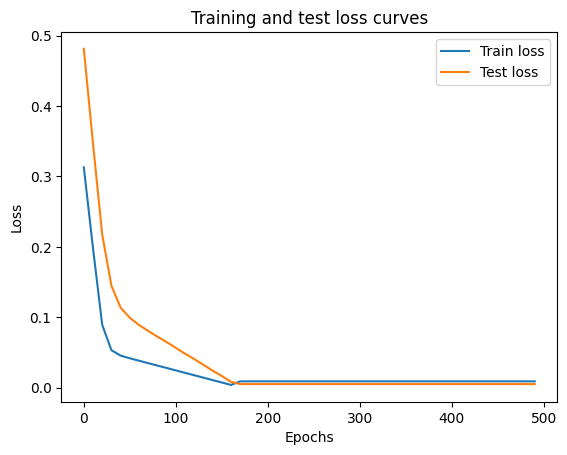

In [26]:
# Plot the loss curves
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [27]:
# The above shows a declining learning curve
# It clearly indicates that after around 190~200 epochs, the loss is not decreasing at all

In [28]:
# Saving a model in Pytorch

# 3 main methods for saving and loading a mode in Pytorch

# 1. torch.save() - (Pytorch uses Pickle behind the scenes that allows you to save PyTorch object in Python's pickle format : https://docs.python.org/3/library/pickle.html)
# 2. torch.load() - allows you to load a saved PyTorch object
# 3. torch.nn.Module.load_state_dict() - allows to load a model's saved state dictionary

# More details here: https://pytorch.org/tutorials/beginner/saving_loading_models.html
# Read about saving and loading entire model vs just saving the state dict. Read in above link

In [30]:
from pathlib import Path

# 1. Create model directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "pytorch_test_model_001.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Stop here, run the code to see if folder is getting created or not

# 3. Save the model state dict
print(f"Saving model to path = { MODEL_SAVE_PATH }")
torch.save(obj=model_one.state_dict(), # not saving the full, saving dict only
           f=MODEL_SAVE_PATH)


# Also, read about how to save Pytorch model from Google Colab to Google Drive:
# https://colab.research.google.com/drive/1CN7JxLA_Qk1Clc4CM75rSAqIlUKIF8xZ

Saving model to path = models/pytorch_test_model_001.pth


In [32]:
# Check if model is saved
!ls -l models

total 4
-rw-r--r-- 1 root root 1187 Aug 30 16:01 pytorch_test_model_001.pth


In [39]:
# Loading the PyTorch model

# Since we saved model's state_dict() and not the entire model, we will create a
# new instance of our model class and load state_dict() into it

# 1. Create instance
loaded_model_one = LinearRegressionModel()
# print(loaded_model_one.state_dict()) # Run this to check its initialized with random params

# 2. Update instance with saved state_dict
loaded_model_one.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
print(loaded_model_one.state_dict())

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])


In [51]:
# Make predictions with loaded model
loaded_model_one.eval()
with torch.inference_mode():
  loaded_model_one_predictions = loaded_model_one(X_test)

loaded_model_one_predictions

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [52]:
# Make predictions again from original model
model_one.eval()
with torch.inference_mode():
  y_preds = model_one(X_test)

In [54]:
# Compare load model's predictions with original model's predictions
y_preds == loaded_model_one_predictions

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [55]:
# Go and read: https://pytorch.org/tutorials/beginner/saving_loading_models.html